In [5]:
!pip install tensorflow-gpu

     ------------------------------------ 455.9/455.9 MB 378.8 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 419.8 kB/s eta 0:00:00
     ------------------------------------ 438.7/438.7 kB 346.9 kB/s eta 0:00:00
     -------------------------------------- 14.2/14.2 MB 440.3 kB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 288.6 kB/s eta 0:00:00
     ------------------------------------ 895.9/895.9 kB 872.5 kB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.0 MB/s eta 0:00:00
     ------------------------------------ 124.6/124.6 kB 914.8 kB/s eta 0:00:00
     ---------------------------------------- 5.9/5.9 MB 524.1 kB/s eta 0:00:00
     -------------------------------------- 42.6/42.6 kB 347.8 kB/s eta 0:00:00
     -------------------------------------- 65.5/65.5 kB 506.8 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 396.9 kB/s eta 0:00:00
     -----------------------------------

In [44]:
pip install opencv-python


     -------------------------------------- 38.2/38.2 MB 279.2 kB/s eta 0:00:00


In [48]:
#import the modules 
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D

import random
import os
import cv2
from IPython.display import Image
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter

In [15]:
#path of image folders
train = 'Mushrooms_3dataset(9528)/train'
test = 'Mushrooms_3dataset(9528)/test'

train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train,target_size=(224,224),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = train_datagen.flow_from_directory(test,target_size=(224,224),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=True)


Found 6664 images belonging to 12 classes.
Found 1911 images belonging to 12 classes.


In [16]:
class_dict = train_generator.class_indices
print(class_dict)
class_dict = {values:key for key,values in class_dict.items()}
print(class_dict)

#convert dictionary to list
class_list = [values for _,values in class_dict.items()]
print(class_list)

{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Exidia': 5, 'Hygrocybe': 6, 'Inocybe': 7, 'Lactarius': 8, 'Pluteus': 9, 'Russula': 10, 'Suillus': 11}
{0: 'Agaricus', 1: 'Amanita', 2: 'Boletus', 3: 'Cortinarius', 4: 'Entoloma', 5: 'Exidia', 6: 'Hygrocybe', 7: 'Inocybe', 8: 'Lactarius', 9: 'Pluteus', 10: 'Russula', 11: 'Suillus'}
['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']


In [17]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [7]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 8
# 8 Images of size each 224x224 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(224,224,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(12,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 104, 64)      204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 166464)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [21]:
filepath = 'log'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = benchmark_model.fit(train_generator,epochs=20, verbose=1, validation_data = test_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

Epoch 1/20
209/209 [==============================] - ETA: 0s - loss: 2.6068 - acc: 0.1059
Epoch 1: val_acc improved from -inf to 0.11251, saving model to log


INFO:tensorflow:Assets written to: log\assets


INFO:tensorflow:Assets written to: log\assets


209/209 [==============================] - 1289s 6s/step - loss: 2.6068 - acc: 0.1059 - val_loss: 2.4592 - val_acc: 0.1125 - lr: 0.0010
Epoch 2/20
209/209 [==============================] - ETA: 0s - loss: 2.4516 - acc: 0.1118
Epoch 2: val_acc did not improve from 0.11251
209/209 [==============================] - 1252s 6s/step - loss: 2.4516 - acc: 0.1118 - val_loss: 2.4469 - val_acc: 0.1125 - lr: 0.0010
Epoch 3/20
209/209 [==============================] - ETA: 0s - loss: 2.4459 - acc: 0.1128
Epoch 3: val_acc did not improve from 0.11251
209/209 [==============================] - 1264s 6s/step - loss: 2.4459 - acc: 0.1128 - val_loss: 2.4450 - val_acc: 0.1125 - lr: 0.0010
Epoch 4/20
209/209 [==============================] - ETA: 0s - loss: 2.4452 - acc: 0.1077
Epoch 4: val_acc improved from 0.11251 to 0.11408, saving model to log


INFO:tensorflow:Assets written to: log\assets


INFO:tensorflow:Assets written to: log\assets


209/209 [==============================] - 1227s 6s/step - loss: 2.4452 - acc: 0.1077 - val_loss: 2.4448 - val_acc: 0.1141 - lr: 0.0010
Epoch 5/20
209/209 [==============================] - ETA: 0s - loss: 2.4451 - acc: 0.1122
Epoch 5: val_acc did not improve from 0.11408
209/209 [==============================] - 1222s 6s/step - loss: 2.4451 - acc: 0.1122 - val_loss: 2.4448 - val_acc: 0.1141 - lr: 0.0010
Epoch 6/20
209/209 [==============================] - ETA: 0s - loss: 2.4451 - acc: 0.1076  
Epoch 6: val_acc did not improve from 0.11408
209/209 [==============================] - 80697s 388s/step - loss: 2.4451 - acc: 0.1076 - val_loss: 2.4448 - val_acc: 0.1141 - lr: 0.0010
Epoch 7/20
209/209 [==============================] - ETA: 0s - loss: 2.4452 - acc: 0.1112
Epoch 7: val_acc did not improve from 0.11408
209/209 [==============================] - 1224s 6s/step - loss: 2.4452 - acc: 0.1112 - val_loss: 2.4448 - val_acc: 0.1141 - lr: 0.0010
Epoch 8/20
209/209 [====================

In [23]:
benchmark_model.save(filepath)


INFO:tensorflow:Assets written to: log\assets


INFO:tensorflow:Assets written to: log\assets


In [24]:
history.history

{'loss': [2.6068015098571777,
  2.4516279697418213,
  2.445936441421509,
  2.4452197551727295,
  2.4451217651367188,
  2.4450886249542236,
  2.445162773132324,
  2.4451522827148438,
  2.4451518058776855],
 'acc': [0.10594237595796585,
  0.11179471760988235,
  0.11284513771533966,
  0.10774309933185577,
  0.11224489659070969,
  0.10759303718805313,
  0.11119447648525238,
  0.11104441434144974,
  0.11224489659070969],
 'val_loss': [2.459156036376953,
  2.4469149112701416,
  2.445002794265747,
  2.4448444843292236,
  2.444793224334717,
  2.4447851181030273,
  2.4448063373565674,
  2.4448001384735107,
  2.4447686672210693],
 'val_acc': [0.11250653862953186,
  0.11250653862953186,
  0.11250653862953186,
  0.1140763983130455,
  0.1140763983130455,
  0.1140763983130455,
  0.1140763983130455,
  0.1140763983130455,
  0.1140763983130455],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

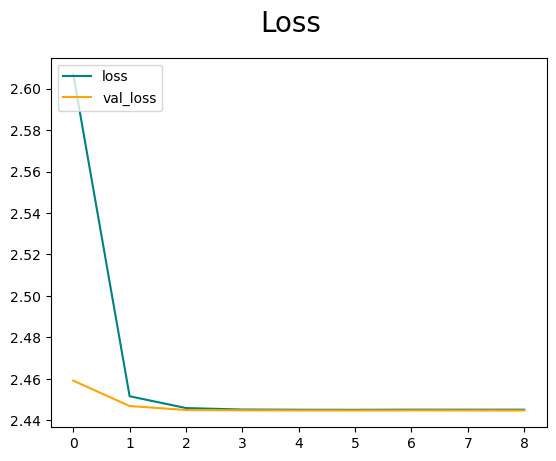

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

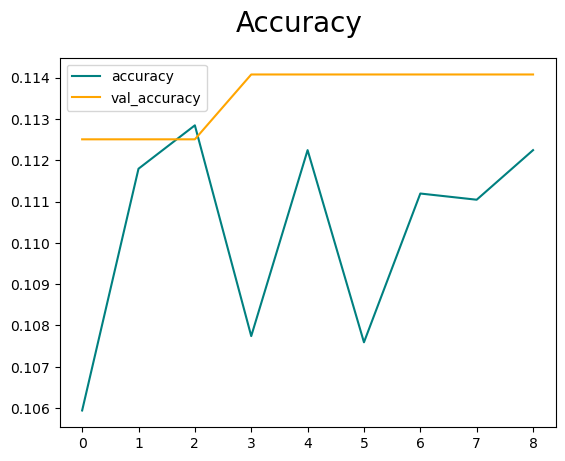

In [27]:
fig = plt.figure()
plt.plot(history.history['acc'], color='teal', label='accuracy')
plt.plot(history.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)


In [8]:
#vgg16
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))

for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(12, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data =  test_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)


Epoch 1/60
209/209 [==============================] - ETA: 0s - loss: 2.1572 - acc: 0.2632
Epoch 1: val_acc improved from -inf to 0.30560, saving model to vgg_16_-saved-model-01-acc-0.31.hdf5
209/209 [==============================] - 1014s 5s/step - loss: 2.1572 - acc: 0.2632 - val_loss: 2.0061 - val_acc: 0.3056
Epoch 2/60
209/209 [==============================] - ETA: 0s - loss: 1.8580 - acc: 0.3715
Epoch 2: val_acc improved from 0.30560 to 0.39927, saving model to vgg_16_-saved-model-02-acc-0.40.hdf5
209/209 [==============================] - 971s 5s/step - loss: 1.8580 - acc: 0.3715 - val_loss: 1.8113 - val_acc: 0.3993
Epoch 3/60
209/209 [==============================] - ETA: 0s - loss: 1.7363 - acc: 0.4149
Epoch 3: val_acc improved from 0.39927 to 0.42177, saving model to vgg_16_-saved-model-03-acc-0.42.hdf5
209/209 [==============================] - 962s 5s/step - loss: 1.7363 - acc: 0.4149 - val_loss: 1.7202 - val_acc: 0.4218
Epoch 4/60
209/209 [==============================]

Epoch 30/60
209/209 [==============================] - ETA: 0s - loss: 1.1419 - acc: 0.6110
Epoch 30: val_acc improved from 0.53375 to 0.54369, saving model to vgg_16_-saved-model-30-acc-0.54.hdf5
209/209 [==============================] - 1045s 5s/step - loss: 1.1419 - acc: 0.6110 - val_loss: 1.3795 - val_acc: 0.5437
Epoch 31/60
209/209 [==============================] - ETA: 0s - loss: 1.1334 - acc: 0.6113
Epoch 31: val_acc did not improve from 0.54369
209/209 [==============================] - 1043s 5s/step - loss: 1.1334 - acc: 0.6113 - val_loss: 1.4288 - val_acc: 0.5191
Epoch 32/60
209/209 [==============================] - ETA: 0s - loss: 1.1349 - acc: 0.6145
Epoch 32: val_acc did not improve from 0.54369
209/209 [==============================] - 1019s 5s/step - loss: 1.1349 - acc: 0.6145 - val_loss: 1.4268 - val_acc: 0.5212
Epoch 33/60
209/209 [==============================] - ETA: 0s - loss: 1.1139 - acc: 0.6209
Epoch 33: val_acc improved from 0.54369 to 0.54422, saving model

209/209 [==============================] - 985s 5s/step - loss: 0.9525 - acc: 0.6699 - val_loss: 1.3777 - val_acc: 0.5489


In [10]:
print(vgg16_model)

In [20]:
import pandas as pd
import seaborn as sns


do_history_stuff(vgg16_history, 'vgg16_model')

Epoch 1/60
209/209 [==============================] - 540s 3s/step - loss: 2.2992 - accuracy: 0.2502 - val_loss: 1.6965 - val_accuracy: 0.4406
Epoch 2/60
209/209 [==============================] - 493s 2s/step - loss: 1.6879 - accuracy: 0.4344 - val_loss: 1.4756 - val_accuracy: 0.5149
Epoch 3/60
209/209 [==============================] - 494s 2s/step - loss: 1.4018 - accuracy: 0.5348 - val_loss: 1.3346 - val_accuracy: 0.5578
Epoch 4/60
209/209 [==============================] - 478s 2s/step - loss: 1.2135 - accuracy: 0.5948 - val_loss: 1.2542 - val_accuracy: 0.5871
Epoch 5/60
209/209 [==============================] - 503s 2s/step - loss: 1.0872 - accuracy: 0.6333 - val_loss: 1.1797 - val_accuracy: 0.5997
Epoch 6/60
209/209 [==============================] - 638s 3s/step - loss: 0.9666 - accuracy: 0.6756 - val_loss: 1.1498 - val_accuracy: 0.6175
Epoch 7/60
209/209 [==============================] - 493s 2s/step - loss: 0.8652 - accuracy: 0.7131 - val_loss: 1.1523 - val_accuracy: 0.6243

209/209 [==============================] - 483s 2s/step - loss: 0.0641 - accuracy: 0.9823 - val_loss: 1.0500 - val_accuracy: 0.7153
Epoch 56/60
209/209 [==============================] - 483s 2s/step - loss: 0.0505 - accuracy: 0.9881 - val_loss: 1.0679 - val_accuracy: 0.7179
Epoch 57/60
209/209 [==============================] - 482s 2s/step - loss: 0.0513 - accuracy: 0.9862 - val_loss: 1.0733 - val_accuracy: 0.7080
Epoch 58/60
209/209 [==============================] - 482s 2s/step - loss: 0.0478 - accuracy: 0.9874 - val_loss: 1.1540 - val_accuracy: 0.7075
Epoch 59/60
209/209 [==============================] - 481s 2s/step - loss: 0.0494 - accuracy: 0.9877 - val_loss: 1.0868 - val_accuracy: 0.7106
Epoch 60/60
209/209 [==============================] - 483s 2s/step - loss: 0.0467 - accuracy: 0.9866 - val_loss: 1.0878 - val_accuracy: 0.7111


C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


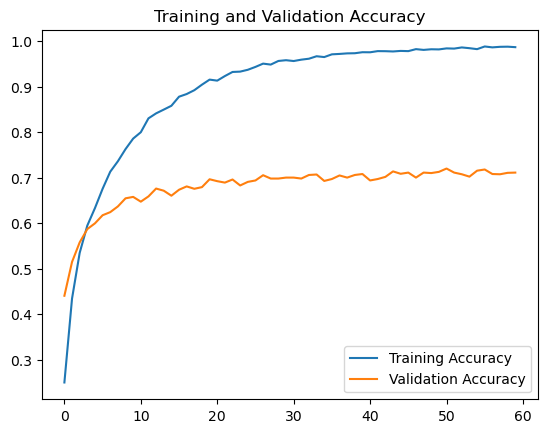

<Figure size 640x480 with 0 Axes>

C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


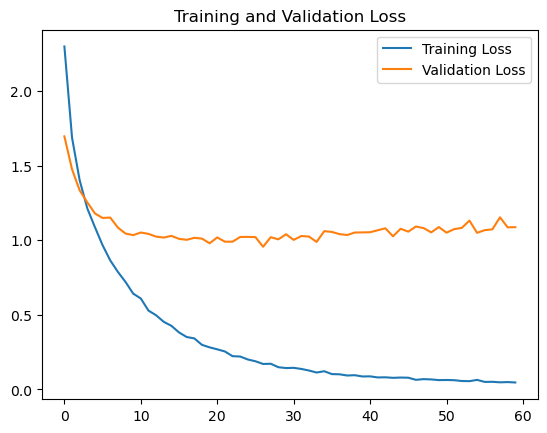

<Figure size 640x480 with 0 Axes>

In [28]:
InceptionV3_model = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(12, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = test_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  


In [2]:
#InceptionV3_x_final_model.save(inception_filepath)

Epoch 1/60
209/209 [==============================] - ETA: 0s - loss: 3.0168 - acc: 0.1541
Epoch 1: val_acc improved from -inf to 0.09995, saving model to resnet50-saved-model-01-val_acc-0.10.hdf5
209/209 [==============================] - 2221s 11s/step - loss: 3.0168 - acc: 0.1541 - val_loss: 2.4900 - val_acc: 0.0999 - lr: 0.0100
Epoch 2/60
209/209 [==============================] - ETA: 0s - loss: 2.1385 - acc: 0.2790
Epoch 2: val_acc did not improve from 0.09995
209/209 [==============================] - 2143s 10s/step - loss: 2.1385 - acc: 0.2790 - val_loss: 2.5307 - val_acc: 0.0649 - lr: 0.0100
Epoch 3/60
209/209 [==============================] - ETA: 0s - loss: 1.9043 - acc: 0.3666
Epoch 3: val_acc did not improve from 0.09995
209/209 [==============================] - 2153s 10s/step - loss: 1.9043 - acc: 0.3666 - val_loss: 2.6978 - val_acc: 0.0654 - lr: 0.0100
Epoch 4/60
209/209 [==============================] - ETA: 0s - loss: 1.6813 - acc: 0.4329
Epoch 4: val_acc did not im

209/209 [==============================] - ETA: 0s - loss: 0.0861 - acc: 0.9736
Epoch 28: val_acc did not improve from 0.62847
209/209 [==============================] - 2130s 10s/step - loss: 0.0861 - acc: 0.9736 - val_loss: 1.5254 - val_acc: 0.6243 - lr: 2.0000e-06
Epoch 29/60
209/209 [==============================] - ETA: 0s - loss: 0.0871 - acc: 0.9730
Epoch 29: val_acc did not improve from 0.62847
209/209 [==============================] - 2131s 10s/step - loss: 0.0871 - acc: 0.9730 - val_loss: 1.5313 - val_acc: 0.6243 - lr: 2.0000e-06
Epoch 30/60
209/209 [==============================] - ETA: 0s - loss: 0.0874 - acc: 0.9736
Epoch 30: val_acc did not improve from 0.62847
209/209 [==============================] - 2128s 10s/step - loss: 0.0874 - acc: 0.9736 - val_loss: 1.5529 - val_acc: 0.6269 - lr: 2.0000e-06
Epoch 31/60
209/209 [==============================] - ETA: 0s - loss: 0.0882 - acc: 0.9731
Epoch 31: val_acc did not improve from 0.62847
209/209 [========================

C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


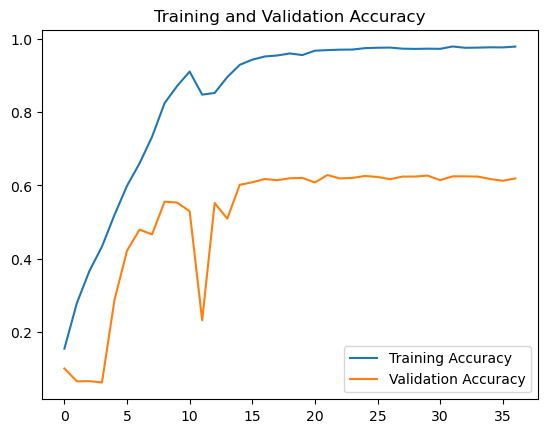

<Figure size 640x480 with 0 Axes>

C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


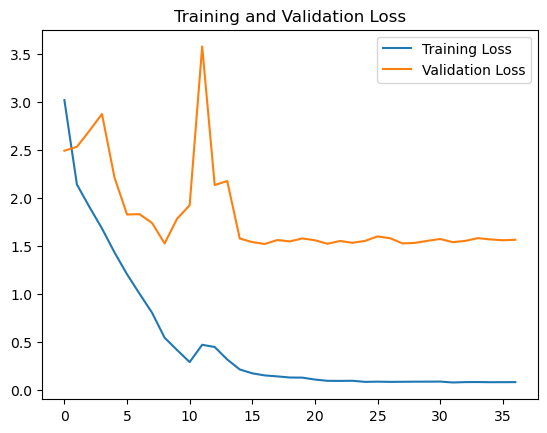

<Figure size 640x480 with 0 Axes>

In [37]:
from keras.callbacks import ReduceLROnPlateau
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=12)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(learning_rate=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(12,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = test_generator,callbacks=[resnet_checkpoint,resnet_early_stopping,reduce_lr],verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')


In [38]:
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

In [49]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(test):
    
    test_image_ids = os.listdir(os.path.join(test,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test,folder,image_id)
        
        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 255ms/step


In [50]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.5138670852956567
              precision    recall  f1-score   support

    Agaricus       0.64      0.60      0.62       195
     Amanita       0.61      0.52      0.56       150
     Boletus       0.65      0.80      0.72       215
 Cortinarius       0.39      0.51      0.45       168
    Entoloma       0.36      0.54      0.43       168
      Exidia       0.63      0.87      0.73        87
   Hygrocybe       0.77      0.57      0.65       149
     Inocybe       0.38      0.31      0.34       124
   Lactarius       0.48      0.22      0.30       218
     Pluteus       0.46      0.26      0.33        89
     Russula       0.44      0.72      0.54       215
     Suillus       0.48      0.10      0.16       133

    accuracy                           0.51      1911
   macro avg       0.52      0.50      0.49      1911
weighted avg       0.52      0.51      0.49      1911



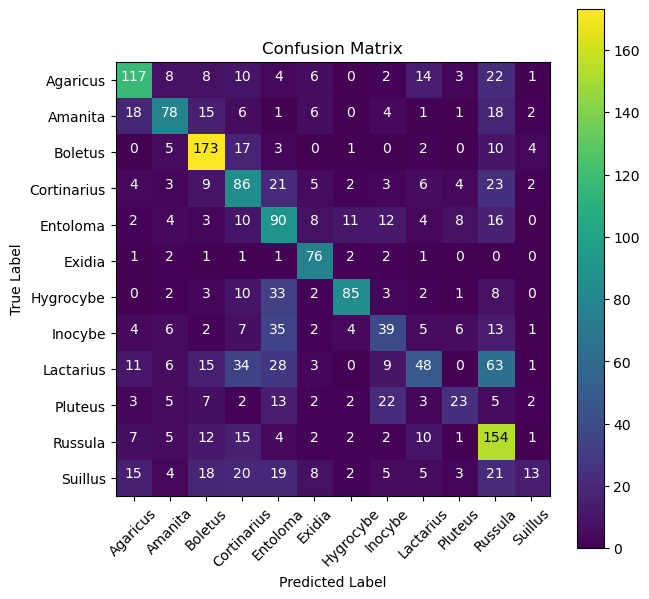

In [51]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.5709052851909995
              precision    recall  f1-score   support

    Agaricus       0.60      0.64      0.62       195
     Amanita       0.59      0.79      0.68       150
     Boletus       0.72      0.82      0.77       215
 Cortinarius       0.56      0.52      0.54       168
    Entoloma       0.36      0.67      0.47       168
      Exidia       0.66      0.95      0.78        87
   Hygrocybe       0.88      0.66      0.76       149
     Inocybe       0.45      0.19      0.26       124
   Lactarius       0.68      0.18      0.29       218
     Pluteus       0.41      0.38      0.40        89
     Russula       0.50      0.76      0.60       215
     Suillus       0.76      0.22      0.34       133

    accuracy                           0.57      1911
   macro avg       0.60      0.57      0.54      1911
weighted avg       0.60      0.57      0.55      1911



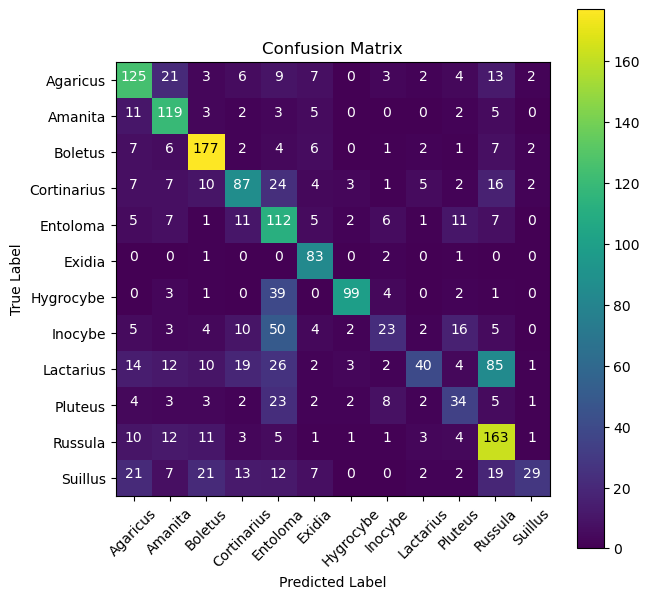

In [52]:
# Inception model classification report
clf_report(true_value, inception_pred)

Model Accuracy 0.35478806907378335
              precision    recall  f1-score   support

    Agaricus       0.35      0.62      0.45       195
     Amanita       0.52      0.45      0.48       150
     Boletus       0.41      0.60      0.48       215
 Cortinarius       0.27      0.15      0.19       168
    Entoloma       0.21      0.40      0.28       168
      Exidia       0.36      0.60      0.45        87
   Hygrocybe       0.49      0.30      0.37       149
     Inocybe       0.20      0.21      0.21       124
   Lactarius       0.42      0.16      0.23       218
     Pluteus       0.30      0.19      0.23        89
     Russula       0.49      0.44      0.46       215
     Suillus       0.14      0.03      0.05       133

    accuracy                           0.35      1911
   macro avg       0.35      0.34      0.32      1911
weighted avg       0.36      0.35      0.33      1911



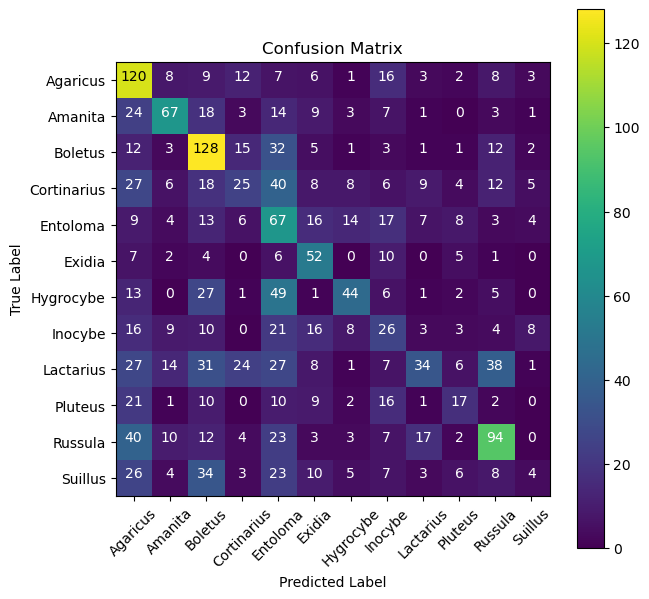

In [53]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.4641548927263213
              precision    recall  f1-score   support

    Agaricus       0.60      0.40      0.48       195
     Amanita       0.55      0.43      0.48       150
     Boletus       0.59      0.73      0.65       215
 Cortinarius       0.35      0.57      0.43       168
    Entoloma       0.33      0.41      0.37       168
      Exidia       0.65      0.82      0.72        87
   Hygrocybe       0.70      0.53      0.60       149
     Inocybe       0.35      0.31      0.33       124
   Lactarius       0.48      0.28      0.35       218
     Pluteus       0.37      0.21      0.27        89
     Russula       0.37      0.65      0.47       215
     Suillus       0.49      0.13      0.20       133

    accuracy                           0.46      1911
   macro avg       0.49      0.45      0.45      1911
weighted avg       0.48      0.46      0.45      1911



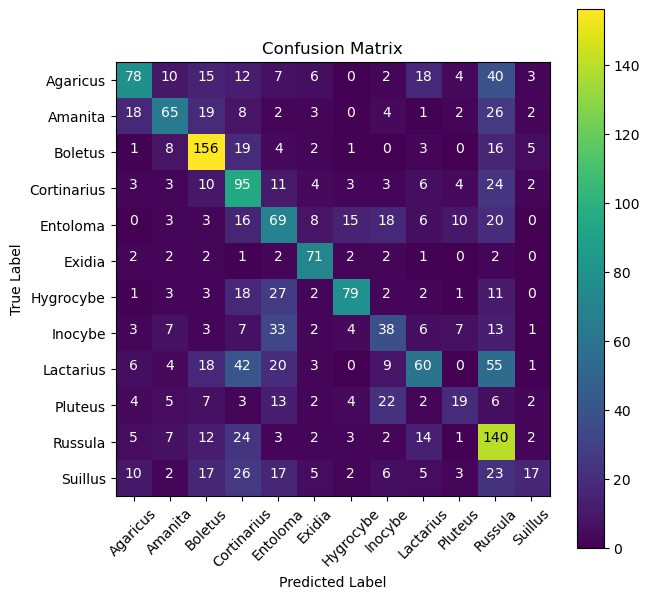

In [54]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.07326007326007326
              precision    recall  f1-score   support

    Agaricus       0.10      0.03      0.05       195
     Amanita       0.00      0.00      0.00       150
     Boletus       0.10      0.00      0.01       215
 Cortinarius       0.00      0.00      0.00       168
    Entoloma       0.00      0.00      0.00       168
      Exidia       0.01      0.01      0.01        87
   Hygrocybe       0.07      0.62      0.13       149
     Inocybe       0.00      0.00      0.00       124
   Lactarius       0.12      0.12      0.12       218
     Pluteus       0.00      0.00      0.00        89
     Russula       0.05      0.02      0.03       215
     Suillus       0.09      0.06      0.07       133

    accuracy                           0.07      1911
   macro avg       0.05      0.07      0.04      1911
weighted avg       0.05      0.07      0.04      1911



C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


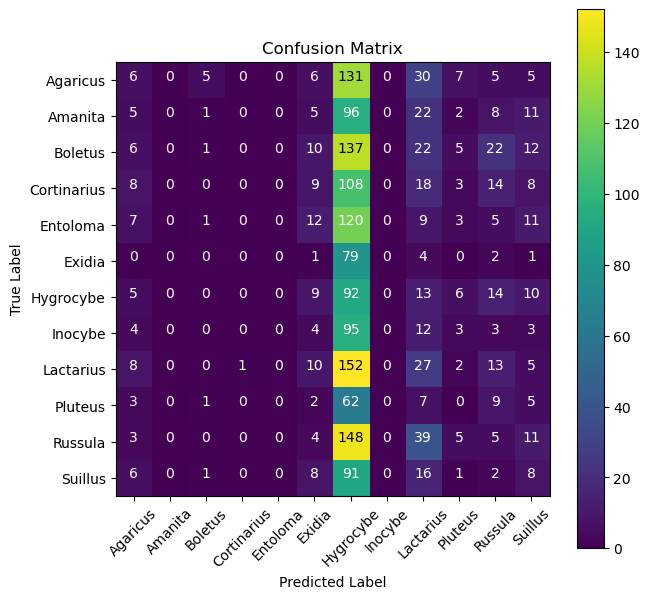

In [55]:
#benchmark model
clf_report(true_value, benchmark_model_pred)